# Language Conditioned Robot Skills (LCRS) - Live Demo

## Load the pre-trained model

In [1]:
from enum import Enum
import os

class Dataset(Enum):
    D = "dataset/task_D_D"
    ABC = "dataset/task_ABC_D"
    ABCD = "dataset/task_ABCD_D"
    debug = "dataset/calvin_debug_dataset"
    
shm = ["vision_lang", "vision_lang_shm"]

In [2]:
#==================================================
# SELECT DATASET YOU WANT TO USE FOR DEMO HERE
#==================================================
selectedDataset = Dataset.debug
useSharedMemory = False

In [30]:
from calvin_agent.utils.utils import print_system_env_info, get_last_checkpoint, format_sftp_path
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import Logger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import Callback, LightningModule, seed_everything, Trainer
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.utilities.cloud_io import load as pl_load
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
import logging
from pathlib import Path
import sys
from typing import List
import lcrs
from lcrs.utils.distribution import Distribution

logger = logging.getLogger(__name__)

with initialize(config_path="./conf"):
    cfg = compose(config_name="config", overrides=[f"datamodule.root_data_dir={selectedDataset.value}"])
#print(OmegaConf.to_yaml(cfg.datamodule))

seed_everything(cfg.seed, workers=True)

datamodule = instantiate(cfg.datamodule, training_repo_root=Path(lcrs.__file__).parents[1])
model = instantiate(cfg.model)
#print(Path.cwd())
#chk = get_last_checkpoint(Path("~/runs/2024-03-07/21-32-22"))
chk = Path("~/runs/2024-03-07/21-32-22/saved_models/epoch=0.ckpt")

if chk:
    #pretrain_chk = pl_load(format_sftp_path(Path(cfg.pretrain_chk)), map_location=lambda storage, loc: storage)
    pretrain_chk = pl_load(format_sftp_path(chk), map_location=lambda storage, loc: storage)
    model.load_state_dict(pretrain_chk["state_dict"], strict=False)
   # model.load_state_dict(chk)

    print("LOADED PRE-TRAINED MODEL")
else:
    raise(Exception("No pre-trained model found"))

#log_rank_0(print_system_env_info())



trainer_args = {
    **cfg.trainer,
    #"logger": train_logger,
    "callbacks": [hydra.utils.instantiate(cb) for cb in cfg.callbacks.values()],
    "benchmark": False,
}
trainer = Trainer(**trainer_args)
#trainer.fit(model, datamodule=datamodule)

#@rank_zero_only
#def log_rank_0(*args, **kwargs):
    #logger.info(*args, **kwargs)



#loaded_model = lcrs.load_from_checkpoint("~/runs/2024-03-07/21-32-22/saved_models/epoch=0.ckpt")



Global seed set to 42


/home/jovyan/lcrs


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


LOADED PRE-TRAINED MODEL


## Setup simulation environment

CALVIN

In [6]:
# Run this to check if the installation was succesful
from calvin_env.envs.play_table_env import PlayTableSimEnv

pybullet build time: Nov 28 2023 23:45:17


In [8]:
from hydra import initialize, compose

with initialize(config_path="./calvin/calvin_env/conf/"):
  cfg = compose(config_name="config_data_collection.yaml", overrides=["cameras=static_and_gripper"])
  cfg.env["use_egl"] = False
  cfg.env["show_gui"] = False
  cfg.env["use_vr"] = False
  cfg.env["use_scene_info"] = True
  print(cfg.env)

{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/core/default_element.py:122: UserWarning: In 'vr_input/vr_controller/vive': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(


dict_keys(['rgb_obs', 'depth_obs', 'robot_obs', 'scene_obs'])


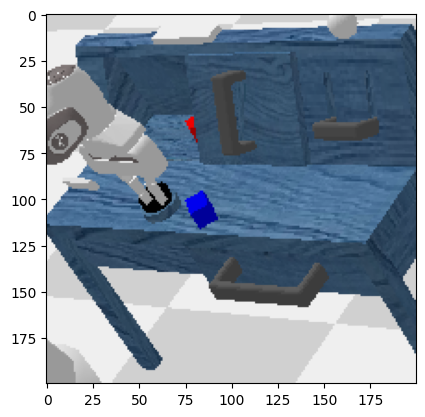

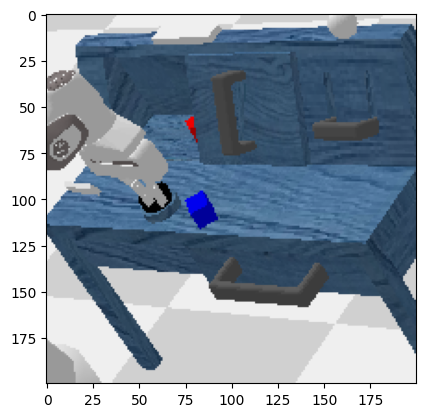

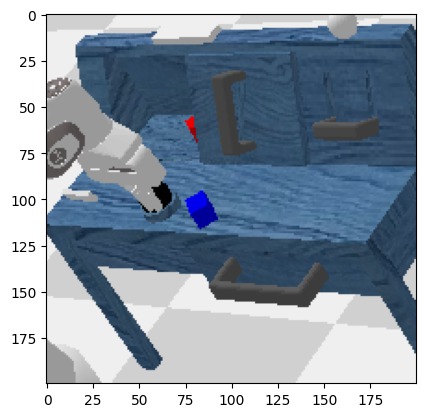

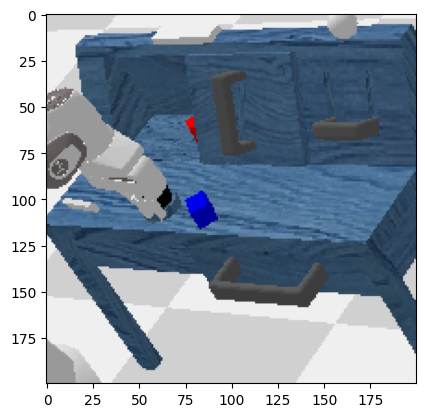

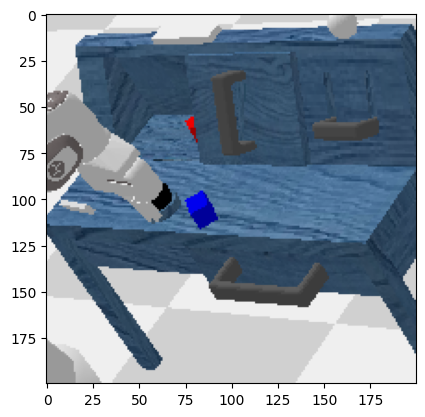

In [9]:
import time
import hydra
import numpy as np
#from google.colab.patches import cv2_imshow
#import cv2 
from matplotlib import pyplot as plt
env = hydra.utils.instantiate(cfg.env)
observation = env.reset()
#The observation is given as a dictionary with different values
print(observation.keys())
for i in range(5):
  # The action consists in a pose displacement (position and orientation)
  action_displacement = np.random.uniform(low=-1, high=1, size=6)
  # And a binary gripper action, -1 for closing and 1 for oppening
  action_gripper = np.random.choice([-1, 1], size=1)
  action = np.concatenate((action_displacement, action_gripper), axis=-1)
  observation, reward, done, info = env.step(action)
  rgb = env.render(mode="rgb_array")[:,:,::-1]
  #cv2_imshow(rgb)

  #Import image
  #image = cv2.imread(rgb)

  #Show the image with matplotlib
  plt.imshow(rgb)
  plt.show()

## Inference

In [ ]:
loaded_model.step() #todo: integrate environment into it and so on
predict
predict_step